In [1]:
import pandas as pd
import numpy as np

In [2]:
WINDOW = 10

### Problem definition
Given the opening and closing prices from the last 10 trading days, and the opening price from the current day, predict whether the closing price will be higher or lower than the opening price

### Data collection
Tesla stock price dataset obtained from Kaggle

In [3]:
df_all_data = pd.read_csv("./Resources/TSLA.csv")
df_all_data["Date"] = pd.to_datetime(df_all_data["Date"])
df_all_data.set_index("Date", inplace=True)
df_all_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-09-30,48.796001,47.222000,48.599998,48.174000,29399000.0,48.174000
2019-10-01,49.189999,47.826000,48.299999,48.938000,30813000.0,48.938000
2019-10-02,48.930000,47.886002,48.658001,48.625999,28157000.0,48.625999
2019-10-03,46.896000,44.855999,46.372002,46.605999,75422500.0,46.605999
2019-10-04,46.956001,45.613998,46.321999,46.285999,39975000.0,46.285999
...,...,...,...,...,...,...
2022-04-05,1152.869995,1087.300049,1136.300049,1091.260010,26691700.0,1091.260010
2022-04-06,1079.000000,1027.699951,1073.469971,1045.760010,29782800.0,1045.760010
2022-04-07,1076.589966,1021.539978,1052.390015,1057.260010,26482400.0,1057.260010


### Data cleaning and preprocessing
- Constrain to opening and closing prices only
- Use sliding window to obtain 21 features
- Scale data to standard normal distribution

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
df_constrained = df_all_data.loc[:, ["Open", "Close"]]
split_point = int(len(df_constrained) * 0.85)
df_training = df_constrained.iloc[:split_point, :]
df_test = df_constrained.iloc[split_point:, :]

In [6]:
scaler = StandardScaler()
np_training = scaler.fit_transform(df_training)
np_test = scaler.transform(df_test)

In [7]:
def sliding_window(array):
    data = []
    labels = []
    for i in range(WINDOW, len(array)):
        opening = array[i-WINDOW:i, 0]
        closing = array[i-WINDOW:i, 1]
        datapoint = [list(t) for t in list(zip(opening, closing))]
        current_open = array[i, 0]
        datapoint.append([current_open, 0])
        current_close = array[i, 1]
        if current_open >= current_close:
            labels.append(1.)
        else:
            labels.append(0.)
        data.append(datapoint)
    return np.array(data), np.array(labels)

In [8]:
X_train, y_train = sliding_window(np_training)
X_test, y_test = sliding_window(np_test)

### EDA
Already completed as part of v0.1.0

### Feature engineering
None required for v0.2.0

### Model selection
Using a PyTorch LSTM via Keras for v0.2.0

### Model training

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

Using device: mps


In [10]:
split_point = int(len(X_train) * 0.85)
X_epoch = X_train[:split_point, :, :]
y_epoch = y_train[:split_point]
X_validate = X_train[split_point:, :, :]
y_validate = y_train[split_point:]

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=32, batch_first=True)
        self.fc1 = nn.Linear(32, 16)
        self.act1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(16, 1)
        self.act2 = nn.Sigmoid()
    
    def forward(self, x, states):
        out, states = self.lstm(x, states)
        out = out[:, -1, :]
        out = self.act1(self.fc1(out))
        out = self.act2(self.fc2(out))
        return out, states
    
    def init_state(self, batch_size):
        hidden = torch.zeros(1, batch_size, 32, device=device)
        cell = torch.zeros(1, batch_size, 32, device=device)
        return hidden, cell

In [12]:
model = LSTMModel(input_size=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [13]:
X_train_t = torch.tensor(X_epoch, dtype=torch.float)
y_train_t = torch.tensor(y_epoch, dtype=torch.float).unsqueeze(1)

X_val_t = torch.tensor(X_validate, dtype=torch.float)
y_val_t = torch.tensor(y_validate, dtype=torch.float).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=32, shuffle=False)

In [14]:
train_losses, val_losses = [], []
epochs = 1000

for epoch in range(epochs):
    model.train()
    running_loss, total = 0.0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        states = model.init_state(X_batch.size(0))
        outputs, states = model(X_batch, states)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        total += y_batch.size(0)
    
    epoch_loss = running_loss / total
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss, val_total = 0.0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            states = model.init_state(X_batch.size(0))
            outputs, states = model(X_batch, states)
            loss = criterion(outputs, y_batch)

            val_running_loss += loss.item() * X_batch.size(0)
            val_total += y_batch.size(0)
        
    val_loss = val_running_loss / val_total
    val_losses.append(val_loss)

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Train Loss = {epoch_loss:.4f}, Val Loss = {val_loss:.4f}")

torch.save(model, "./Resources/model2.pth")

Epoch 0: Train Loss = 0.6949, Val Loss = 0.6936
Epoch 50: Train Loss = 0.6799, Val Loss = 0.7283
Epoch 100: Train Loss = 0.6736, Val Loss = 0.7407
Epoch 150: Train Loss = 0.6713, Val Loss = 0.7458
Epoch 200: Train Loss = 0.6667, Val Loss = 0.7354
Epoch 250: Train Loss = 0.6519, Val Loss = 0.8234
Epoch 300: Train Loss = 0.6486, Val Loss = 0.9537
Epoch 350: Train Loss = 0.6410, Val Loss = 1.1137
Epoch 400: Train Loss = 0.6298, Val Loss = 1.3251
Epoch 450: Train Loss = 0.6113, Val Loss = 1.3603
Epoch 500: Train Loss = 0.6095, Val Loss = 1.4713
Epoch 550: Train Loss = 0.6141, Val Loss = 1.4499
Epoch 600: Train Loss = 0.5740, Val Loss = 1.5505
Epoch 650: Train Loss = 0.5557, Val Loss = 1.7466
Epoch 700: Train Loss = 0.5421, Val Loss = 1.9672
Epoch 750: Train Loss = 0.5365, Val Loss = 2.0446
Epoch 800: Train Loss = 0.5440, Val Loss = 2.0278
Epoch 850: Train Loss = 0.5018, Val Loss = 2.5817
Epoch 900: Train Loss = 0.4901, Val Loss = 2.5499
Epoch 950: Train Loss = 0.5742, Val Loss = 2.4373


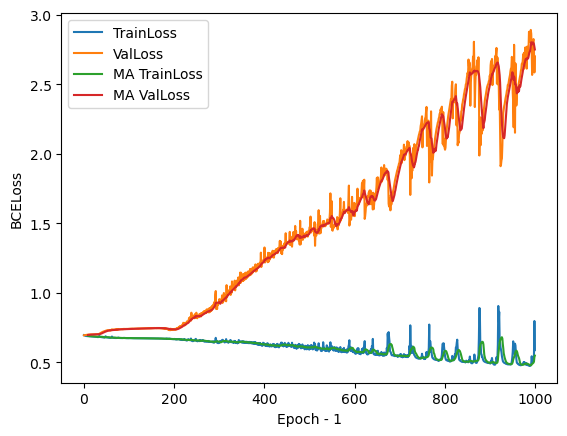

In [15]:
fig, ax = plt.subplots()
df_losses = pd.DataFrame(zip(train_losses, val_losses), columns=["TrainLoss", "ValLoss"])
df_losses["MA TrainLoss"] = df_losses["TrainLoss"].rolling(window=10).mean()
df_losses["MA ValLoss"] = df_losses["ValLoss"].rolling(window=10).mean()
df_losses.plot.line(ax=ax)
ax.set_xlabel("Epoch - 1")
ax.set_ylabel("BCELoss")
ax.legend()
plt.show()

### Model evaluation and tuning
No tuning for v0.2.0

In [23]:
X_test_t = torch.tensor(X_test, dtype=torch.float)
y_test_t = torch.tensor(y_test, dtype=torch.float)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=32, shuffle=False)
y_pred = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        states = model.init_state(X_batch.size(0))
        outputs, states = model(X_batch, states)

        conversion = (outputs > 0.5).float().flatten()
        y_pred += conversion.tolist()

In [24]:
report = classification_report(y_test, y_pred, zero_division=np.nan)
print(report)

              precision    recall  f1-score   support

         0.0       0.40      0.04      0.08        45
         1.0       0.47      0.93      0.62        41

    accuracy                           0.47        86
   macro avg       0.43      0.49      0.35        86
weighted avg       0.43      0.47      0.34        86

